In [9]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from bs4 import BeautifulSoup

# Define the list of gun-related words
gun_related_words = ['gun', '2nd amendment', 'second amendment', 'ar-15', 'assault rifle', 'pistols', 'shooting', 'mass shooting', 'school shooting', 'march for our lives']

# Function to check if any word from the list is present in the text
def contains_word(text, word_list):
    if pd.isnull(text):  # Check if the text is NaN
        return 0
    for word in word_list:
        if word.lower() in text.lower():  # Case insensitive match
            return 1
    return 0

# Load the CSV file into a pandas DataFrame
data = pd.read_csv('jack_handcode.csv')

# Create the new column 'gunsentiment'
data['gunsentiment'] = data['message'].apply(lambda x: contains_word(x, gun_related_words))

# Calculate number of documents
num_documents = len(data)

# Calculate average document length (in terms of words)
data['word_count'] = data['message'].apply(lambda x: len(str(x).split()))
average_doc_length = data['word_count'].mean()

# Distribution of document lengths
doc_length_distribution = data['word_count'].describe()

# Balance of the dataset
label_distribution = data['gunsentiment'].value_counts(normalize=True)

print("Number of Documents:", num_documents)
print("Average Document Length (in words):", average_doc_length)
print("\nDistribution of Document Lengths:")
print(doc_length_distribution)
print("\nBalance of the Dataset:")
print(label_distribution)

# Filter documents related to gun legislation
gun_legislation_messages = data[data['dummy_label'] == 1]['message'].dropna().tolist()


# Convert ENGLISH_STOP_WORDS to a list
stop_words_list = list(ENGLISH_STOP_WORDS)

# Create TF-IDF vectorizer with text cleaning and stop words removal
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words_list, preprocessor=clean_text)

# Fit and transform the documents
tfidf_matrix = tfidf_vectorizer.fit_transform(gun_legislation_messages)

# Get feature names (words)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Sum TF-IDF scores for each word across documents
word_scores = tfidf_matrix.sum(axis=0)

# Sort the words by TF-IDF score in descending order
sorted_word_indices = word_scores.argsort()[0, ::-1]

# Display the top words associated with gun legislation
print("\nTop words associated with gun legislation:")
for i in range(10):  # Display top 10 words
    word_index = sorted_word_indices[0, i]
    word = tfidf_feature_names[word_index]
    score = word_scores[0, word_index]
    print(f"{word}: {score}")

# Create CountVectorizer with text cleaning and stop words removal
count_vectorizer = CountVectorizer(stop_words=stop_words_list, preprocessor=clean_text)

# Fit and transform the documents
X = count_vectorizer.fit_transform(gun_legislation_messages)

# Perform LDA
lda = LatentDirichletAllocation(n_components=2, random_state=42)  # Change n_components as needed
lda.fit(X)

# Display the top words for each topic
feature_names = count_vectorizer.get_feature_names_out()
print("\nTop words for each topic:")
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx}:")
    top_words_indices = topic.argsort()[:-11:-1]  # Display top 10 words
    top_words = [feature_names[i] for i in top_words_indices]
    print(", ".join(top_words))

# Perform sentiment analysis for each message
nltk.download('vader_lexicon')  # Download the lexicon required for sentiment analysis
sid = SentimentIntensityAnalyzer()

# Perform sentiment analysis for each message
sentiments = []
for message in data['message']:
    if pd.notnull(message):
        message = str(message)  # Ensure message is a string
        sentiment_score = sid.polarity_scores(message)
        # Classify sentiment based on compound score
        if sentiment_score['compound'] >= 0.05:
            sentiment = 'Positive'
        elif sentiment_score['compound'] <= -0.05:
            sentiment = 'Negative'
        else:
            sentiment = 'Neutral'
    else:
        sentiment = 'Neutral'
    sentiments.append(sentiment)

# Add the sentiment labels to the DataFrame
data['sentiment'] = sentiments

# Display the DataFrame with sentiment labels
print("\nSentiment analysis results:")
print(data[['message', 'sentiment']])

Number of Documents: 4000
Average Document Length (in words): 60.8745

Distribution of Document Lengths:
count    4000.000000
mean       60.874500
std       122.760754
min         2.000000
25%        23.000000
50%        37.000000
75%        58.000000
max      1833.000000
Name: word_count, dtype: float64

Balance of the Dataset:
gunsentiment
0    0.74925
1    0.25075
Name: proportion, dtype: float64


NameError: name 'fbpac_captioned' is not defined

In [13]:
#overall sentiment
# Load the dataset containing political text data (e.g., speeches, news articles)
political_data = pd.read_csv('areen-prehandcode.csv')

# Initialize the sentiment analyzer
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

# Perform sentiment analysis for each political text
# Ensure message is a string
political_data['message'] = political_data['message'].astype(str)
political_data['sentiment_score'] = political_data['message'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Classify sentiment based on the compound score
political_data['sentiment'] = political_data['sentiment_score'].apply(lambda x: 'Positive' if x >= 0.05 else ('Negative' if x <= -0.05 else 'Neutral'))

# Analyze sentiment distribution
sentiment_distribution = political_data['sentiment'].value_counts(normalize=True)

# Display sentiment distribution
print("Sentiment Distribution:")
print(sentiment_distribution)

# Display the DataFrame with sentiment labels
print("\nSentiment analysis results:")
print(political_data[['message', 'sentiment']])

Sentiment Distribution:
sentiment
Positive    0.666667
Negative    0.223744
Neutral     0.109589
Name: proportion, dtype: float64

Sentiment analysis results:
                                               message sentiment
0    <p>Refugee women are breadwinners, caretakers ...  Positive
1    <p>Is your church ready for Refugee Sunday?</p...  Positive
2    <p>We're launching a new version of IN THESE T...  Positive
3    <p>We’re a campaign that deeply believes that ...  Negative
4    <p>These women are pee’d off.</p><p> Curious? ...  Positive
..                                                 ...       ...
214  <p>I am asking you to make a contribution to o...  Positive
215  <span class="fwn fcg"><span class="fcg"><span ...  Positive
216  <p>“One thing that’s obvious is that the defea...  Negative
217  <p>I’ll be blunt: I need you to take my poll b...  Positive
218  <p>The biggest network of conservatives you'll...  Positive

[219 rows x 2 columns]


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Areen\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [14]:
#focused on gun_leg
# Load the dataset containing political text data (e.g., speeches, news articles)
political_data = pd.read_csv('areen-prehandcode.csv')

# Filter the data to include only entries where Gun_leg is 1
gun_leg_data = political_data[political_data['Gun_leg'] == 1]

# Initialize the sentiment analyzer
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

# Perform sentiment analysis for each political text related to gun legislation
gun_leg_data['sentiment_score'] = gun_leg_data['message'].apply(lambda x: sid.polarity_scores(str(x))['compound'])

# Classify sentiment based on the compound score
gun_leg_data['sentiment'] = gun_leg_data['sentiment_score'].apply(lambda x: 'Positive' if x >= 0.05 else ('Negative' if x <= -0.05 else 'Neutral'))

# Analyze sentiment distribution
sentiment_distribution = gun_leg_data['sentiment'].value_counts(normalize=True)

# Display sentiment distribution
print("Sentiment Distribution for Gun Legislation Messages:")
print(sentiment_distribution)

Sentiment Distribution for Gun Legislation Messages:
sentiment
Negative    0.666667
Positive    0.333333
Name: proportion, dtype: float64


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Areen\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
C:\Users\Areen\AppData\Local\Temp\ipykernel_24932\3499118567.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gun_leg_data['sentiment_score'] = gun_leg_data['message'].apply(lambda x: sid.polarity_scores(str(x))['compound'])
C:\Users\Areen\AppData\Local\Temp\ipykernel_24932\3499118567.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g

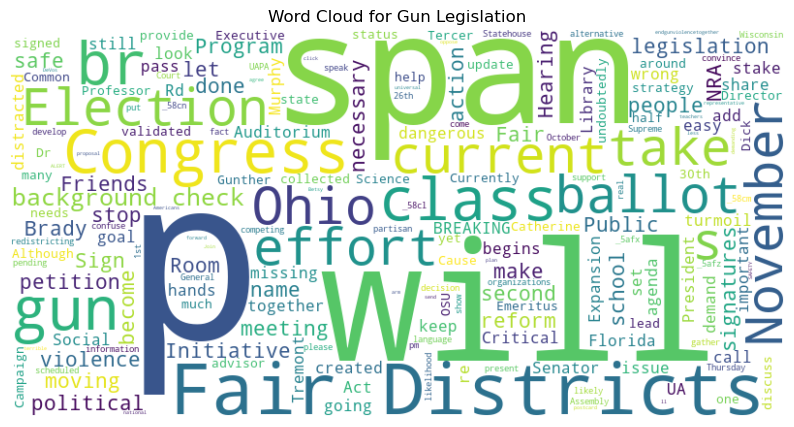

In [15]:
#!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'areen-prehandcode.csv'
data = pd.read_csv(file_path)

# Filter the text data to include only messages containing gun-related words
pattern = '|'.join([re.escape(word) for word in gun_related_words])
gun_legislation_messages = data[data['message'].str.contains(pattern, case=False, na=False)]['message']

# Concatenate the filtered messages into a single string
text = ' '.join(gun_legislation_messages)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Gun Legislation')
plt.show()

Column names in the dataset:
Index(['id', 'html', 'political', 'not_political', 'title', 'Gun_leg',
       'message', 'thumbnail', 'created_at', 'updated_at',
       ...
       'Unnamed: 173', 'Unnamed: 174', 'Unnamed: 175', 'Unnamed: 176',
       'Unnamed: 177', 'Unnamed: 178', 'Unnamed: 179', 'Unnamed: 180',
       'Unnamed: 181', 'Unnamed: 182'],
      dtype='object', length=183)
Number of filtered samples: 3


c:\Users\Areen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


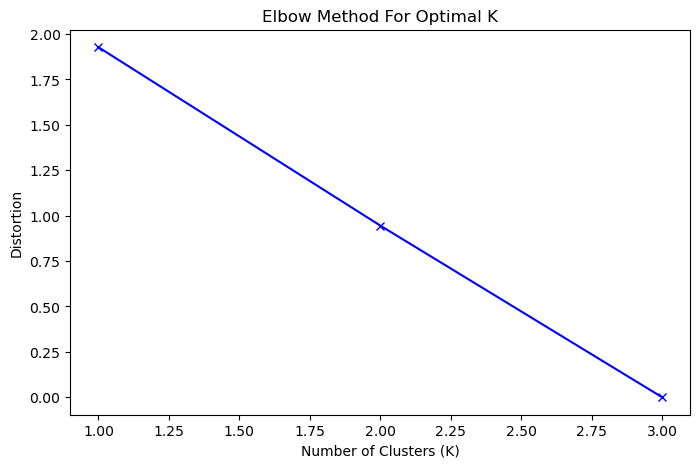

C:\Users\Areen\AppData\Local\Temp\ipykernel_24932\1197413628.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['cluster'] = kmeans.labels_


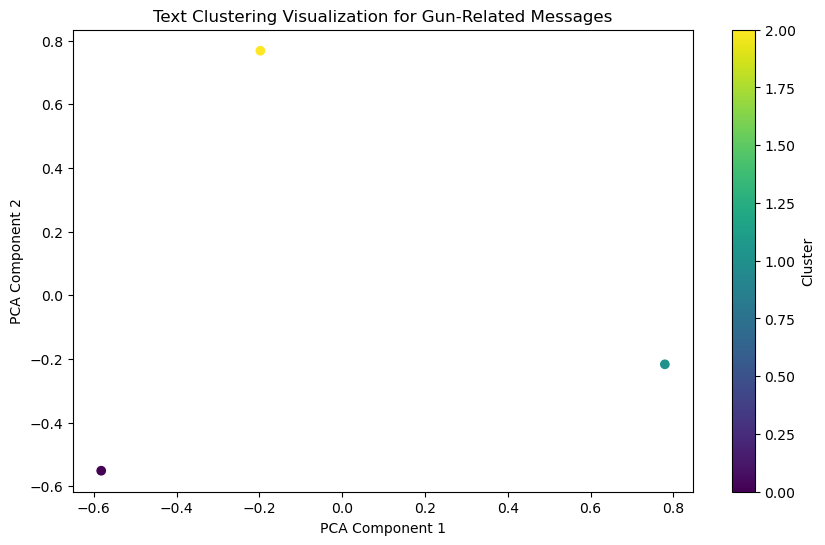

Top terms per cluster:
Cluster 0:
congress
background
brady
check
wrong
demand
missing
legislation
hands
guns

Cluster 1:
safe
ll
safety
join
devos
make
national
oppose
friends
plan

Cluster 2:
going
let
stake
share
look
seconds
election
florida
stop
violence



In [17]:
# Function to check if any word from the list is present in the text
def contains_word(text, word_list):
    if pd.isnull(text):  # Check if the text is NaN
        return False
    for word in word_list:
        if re.search(r'\b' + re.escape(word) + r'\b', text, re.IGNORECASE):
            return True
    return False

# Load the dataset containing text data
# Replace 'your_data.csv' with the path to your dataset
data = pd.read_csv('areen-prehandcode.csv')

# Check and print the column names to verify the correct column name for text data
print("Column names in the dataset:")
print(data.columns)


# Replace 'text' with the actual column name that contains the text data
text_column = 'message'  # Change this to the correct column name

# Filter the dataset to include only messages containing gun-related words
filtered_data = data[data[text_column].apply(lambda x: contains_word(x, gun_related_words))]

# Print the number of filtered samples
num_samples = len(filtered_data)
print(f"Number of filtered samples: {num_samples}")

# Ensure there are enough samples for clustering
if num_samples < 2:
    raise ValueError("Not enough samples for clustering. Please ensure the dataset has enough data points.")

# Create TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=1000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(filtered_data[text_column])

# Perform dimensionality reduction for visualization
pca = PCA(n_components=2)
tfidf_matrix_pca = pca.fit_transform(tfidf_matrix.toarray())

# Determine the optimal number of clusters (K) using the elbow method
distortions = []
K = range(1, min(11, num_samples + 1))  # Ensure K is not more than the number of samples
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix)
    distortions.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Distortion')
plt.title('Elbow Method For Optimal K')
plt.show()

# Choose the optimal number of clusters based on the elbow curve (e.g., K=3, K=4)
# Perform K-means clustering
num_clusters = 3  # Change this value based on the elbow curve analysis and number of samples
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)

# Add cluster labels to the DataFrame
filtered_data['cluster'] = kmeans.labels_

# Visualize clusters in 2D space
plt.figure(figsize=(10, 6))
plt.scatter(tfidf_matrix_pca[:, 0], tfidf_matrix_pca[:, 1], c=filtered_data['cluster'], cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Text Clustering Visualization for Gun-Related Messages')
plt.colorbar(label='Cluster')
plt.show()

# Print the top terms per cluster
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names_out()
for i in range(num_clusters):
    print(f"Cluster {i}:")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]}")
    print()